# WGAN Divergence (WGAN-Div)
*This notebook was run by Arsyi Syarief Aziz (H071191003) for the Introduction to Deep Learning course (Unhas) taught by Dr. Risman Adnan.*

-------
This notebook is adapted from the UI-SRIN Introduction to GANs github repository (https://github.com/DSC-UI-SRIN/Introduction-to-GAN/blob/master/2%20-%20Wasserstein%20GANs/WGAN.ipynb).

## Introduction
In this notebook I will implement the Wassertein GAN (WGAN) algorithm with Wasserstein divergence (W-div) to generate synthetic images that resemble images in the CIFAR10 dataset. 

This algorithm works by approximating W-div through optimization.

## 1. Importing Libraries and Configuring the Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.autograd as autograd
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT = "/content/drive/My Drive/Colab Notebooks/WGANs/WGAN-Div"
sample_dir = os.path.join(ROOT, 'sample')
# Make dir if no exist
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## 2. Dataset

### 2.1 Importing the dataset

In [3]:
batch_size = 100

# FashionMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./FashionMNNIST/', train=True, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)


In [4]:
example_data.shape

torch.Size([100, 1, 28, 28])

In [5]:
LABELS = ['T-shirt/top',
'Trouser',
'Pullover',
'Dress',
'Coat',
'Sandal',
'Shirt',
'Sneaker',
'Bag',
'Ankle boot'
]

### 2.2 Previewing the dataset

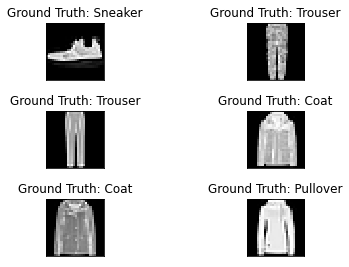

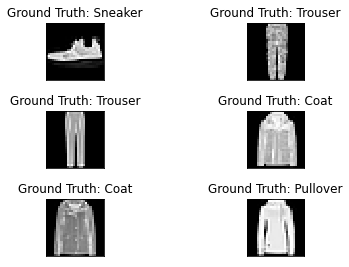

In [6]:
## Print example
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(LABELS[example_targets[i]]))
  plt.xticks([])
  plt.yticks([])
fig

## 3. Building the models

### 3.1 The Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(g_input_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, g_output_dim), 
            nn.Tanh())

    def forward(self, z):
        image = self.model(z)
        image = image.view(image.size(0), -1)
        return image

### 3.2 The Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(d_input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, image):
        img_flat = image.view(image.size(0), -1)
        validity = self.model(img_flat)
        return validity

## 4. Building the Network

In [9]:
# build network
z_dim = 100
cfar10_dim = train_dataset.data.shape[1] * train_dataset.data.shape[2] 
G = Generator(g_input_dim = z_dim, g_output_dim = cfar10_dim).to(device)
D = Discriminator(cfar10_dim).to(device)

In [10]:
print(G, D)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
) Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)

## 6. Training the Model

In [11]:
k = 2
p = 6

# optimizer
lr = 0.0002
n_critic =  3
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))

In [12]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
epochs = 200
list_loss_D = []
list_loss_G = []
for epoch in range(epochs):

    for i, (imgs, _) in enumerate(train_loader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], z_dim))))

        # Generate a batch of images
        fake_imgs = G(z)

        # Real images
        real_validity = D(real_imgs)

        # Fake images
        fake_validity = D(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # -----------------
        #  Train Generator
        # -----------------
        if i % n_critic == 0:

            # Generate a batch of images
            gen_imgs = G(z)
            # Adversarial loss
            g_loss = -torch.mean(D(gen_imgs))

            g_loss.backward()
            optimizer_G.step()

            list_loss_D.append(d_loss.item())
            list_loss_G.append(g_loss.item())
        if i % 300 == 0:
            print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, epochs, i, len(train_loader), d_loss.item(), g_loss.item()))

    if epoch % 5 == 0:
        save_image(gen_imgs.view(gen_imgs.size(0), 1, 28, 28), os.path.join(sample_dir, "%d.png" % epoch), nrow=5, normalize=True)

torch.save(G, os.path.join(ROOT,'G.pt'))
torch.save(D, os.path.join(ROOT,'D.pt'))

[Epoch 0/200] [Batch 0/600] [D loss: -0.012244] [G loss: -0.482533]
[Epoch 0/200] [Batch 300/600] [D loss: 0.001807] [G loss: -0.999594]
[Epoch 1/200] [Batch 0/600] [D loss: 0.000346] [G loss: -0.999994]
[Epoch 1/200] [Batch 300/600] [D loss: 0.000116] [G loss: -1.000000]
[Epoch 2/200] [Batch 0/600] [D loss: 0.000012] [G loss: -1.000000]
[Epoch 2/200] [Batch 300/600] [D loss: 0.000005] [G loss: -1.000000]
[Epoch 3/200] [Batch 0/600] [D loss: 0.000006] [G loss: -1.000000]
[Epoch 3/200] [Batch 300/600] [D loss: 0.000003] [G loss: -1.000000]
[Epoch 4/200] [Batch 0/600] [D loss: 0.000005] [G loss: -1.000000]
[Epoch 4/200] [Batch 300/600] [D loss: 0.000000] [G loss: -1.000000]
[Epoch 5/200] [Batch 0/600] [D loss: 0.000011] [G loss: -1.000000]
[Epoch 5/200] [Batch 300/600] [D loss: 0.000001] [G loss: -1.000000]
[Epoch 6/200] [Batch 0/600] [D loss: 0.000025] [G loss: -1.000000]
[Epoch 6/200] [Batch 300/600] [D loss: 0.000001] [G loss: -1.000000]
[Epoch 7/200] [Batch 0/600] [D loss: 0.000002] 

## 7. Viewing the results

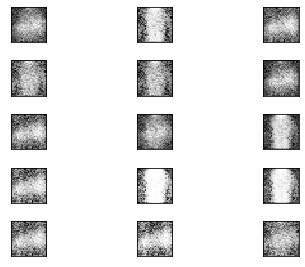

In [13]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
z = Variable(Tensor(np.random.normal(0, 1, (15, z_dim))))
gen_imgs = G(z).detach()
fig = plt.figure()
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.tight_layout()
    plt.imshow(gen_imgs[i].cpu().view(28, 28), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])